# Dog Breed Image Classification Model

## Setup

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
# making sure that tensorflow is going to be using GPU for calculations
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

In [9]:
# set up connection to folder
data_dir = "../Dog_Breed_Files/Images/"
data_dir = pathlib.Path(data_dir)

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20580


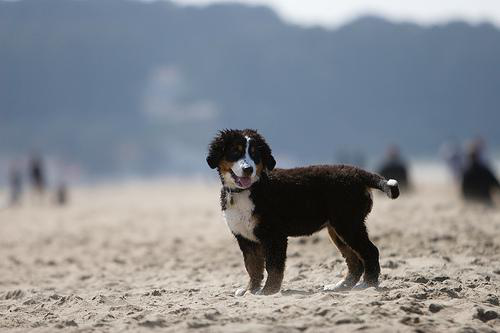

In [15]:
# confirm connection by checking out a bernese mountain dog
dog = list(data_dir.glob('n02107683-Bernese_mountain_dog/*'))
PIL.Image.open(str(dog[51]))

## Set up Data

While we're aware of the "image_dataset_from_directory()" keras utility, we're going to set up a custom image preprocessing pipeline for maximum flexibility with tuning model parameters and for deploying the model later.

We will want all of the images to be the same size. As of now we're unclear what size is going to be the best tradeoff between keeping enough detail and computation speed. Starting off at 250x250.

In [17]:
# define parameters to be used in loading and modeling
batch_size = 32
img_height = 250
img_width = 250

In [125]:
# set up a list that contains every photo in the directory
image_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
image_list = image_list.shuffle(image_count, reshuffle_each_iteration=False)

### Building Class Labels

In [37]:
# investigate the file path for the photos
for image in image_list.take(3):
    print(image.numpy())

b'..\\Dog_Breed_Files\\Images\\n02109961-Eskimo_dog\\n02109961_1678.jpg'
b'..\\Dog_Breed_Files\\Images\\n02105641-Old_English_sheepdog\\n02105641_2750.jpg'
b'..\\Dog_Breed_Files\\Images\\n02085782-Japanese_spaniel\\n02085782_382.jpg'


In [63]:
# note the folder names have a lot of extra info in them. when we get an answer at the end we'll use a dataframe to grab the cleaned name from the messy folder name
class_names = []

for folder_name in os.listdir("../Dog_Breed_Files/Images/"):
    class_names.append(folder_name)

### Set up Train/Test Split

Going to use an 80/20 train test split here. (can revisit later)

In [148]:
test_size = int(image_count*0.2)
train_data = image_list.skip(test_size)
test_data = image_list.take(test_size)

In [111]:
# check size of our training and testing data (expecting sum to be 20,580)
print(tf.data.experimental.cardinality(train_data).numpy())
print(tf.data.experimental.cardinality(test_data).numpy())
print(tf.data.experimental.cardinality(train_data).numpy() + tf.data.experimental.cardinality(test_data).numpy())

16464
4116
20580


### Functions for loading and preprocessing

In [71]:
# this will look at the file path and assign it a number [0-119] based on which dog breed it is (number is relative to where it lies in the folder structure)
def get_label(file_path):
    # take the path and separate it into components by the /
    parts = tf.strings.split(file_path, os.path.sep)
    
    # looking at the file structure above, the 2nd to last element is the class directory
    one_hot = parts[-2] == class_names

    # integer encode the label
    label = tf.argmax(one_hot)
    return label

In [85]:
# this will look at the image in a file path, turn it into an RGB array, then resize it to our desired size
def decode_image(img):
    img = tf.io.read_file(img)

    # parse the image as a uint8 tensor, 3 channels for RGB color
    img = tf.image.decode_jpeg(img, channels=3)

    # convert color channels from [0-255] to [0-1]. done here as opposed to in a model layer for increased efficiency
    img = tf.image.convert_image_dtype(img, tf.float32)

    # resize the image to  standardized size
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [96]:
# this will combine the two functions above to get a label and an encoded tensor for each image it looks at
def processing(file_path):
    # get the folder name
    label = get_label(file_path)
    
    # load image, decode image
    img = decode_image(file_path)
    return img, label

In [149]:
# map the processing pipeline to each data set. 
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(processing)
test_data = test_data.map(processing)

In [150]:
# expecting each image to be (250, 250, 3) shape
for image, label in train_data.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (250, 250, 3)
Label:  49
Image shape:  (250, 250, 3)
Label:  13
Image shape:  (250, 250, 3)
Label:  58


### Set up performance features

In [151]:
def performance_enhance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [152]:
train_data = performance_enhance(train_data)
test_data = performance_enhance(test_data)

### Visualize what we have

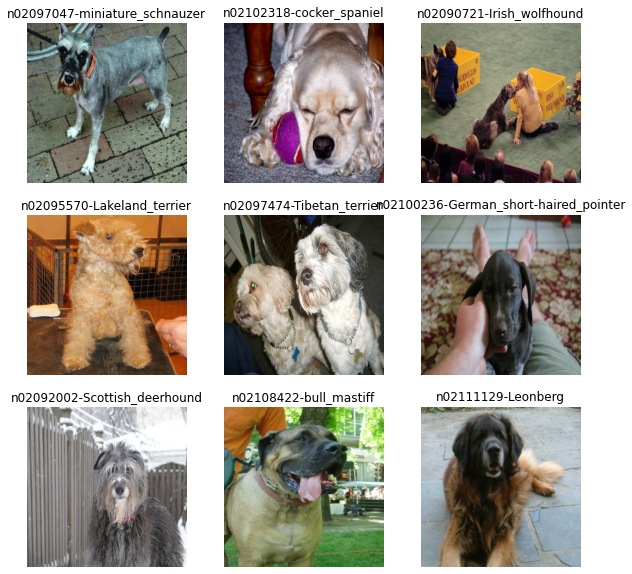

In [157]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Basic Model

We know from researching that a Convolutional Neural Network (CNN) is most often used to classify images. We'll run our image through multiple tf.keras.tf.keras.tf.keras.layers of convolution and pooling and then use "flatten" to turn that array into a vector that can be read by the dense layers that follow.

We'll use the Adam optimizer. and since this is a multi-cateogry categorization problem we'll use the Sparse Categorical Crossentropy loss function.

In [178]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(240, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [179]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [180]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 64)      

In [183]:
epochs = 5
history = model.fit(
  train_data,
  validation_data=test_data,
  epochs=epochs
)

Epoch 1/5
515/515 [==============================] - 16s 32ms/step - loss: 0.3486 - accuracy: 0.9179 - val_loss: 14.1587 - val_accuracy: 0.0389
Epoch 2/5
515/515 [==============================] - 16s 31ms/step - loss: 0.2421 - accuracy: 0.9442 - val_loss: 15.2460 - val_accuracy: 0.0454
Epoch 3/5
515/515 [==============================] - 16s 32ms/step - loss: 0.1722 - accuracy: 0.9615 - val_loss: 16.5597 - val_accuracy: 0.0445
Epoch 4/5
515/515 [==============================] - 16s 32ms/step - loss: 0.1179 - accuracy: 0.9719 - val_loss: 17.2601 - val_accuracy: 0.0442
Epoch 5/5
515/515 [==============================] - 16s 32ms/step - loss: 0.1118 - accuracy: 0.9738 - val_loss: 17.3720 - val_accuracy: 0.0403


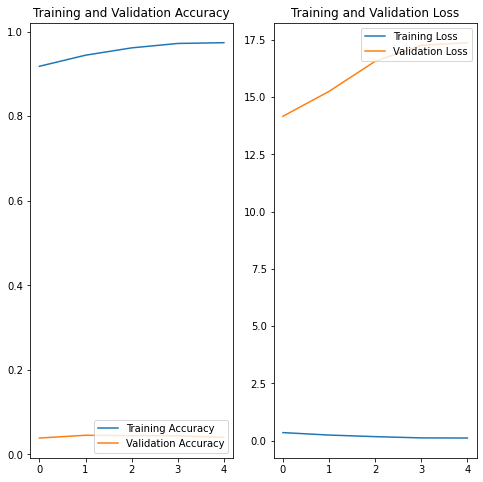

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

Since there are only 200ish photos for each dog breed this model is a good candidate for data augmentation, where we randomly scale, rotate, and translate the photos in order to make each photo give more information to the model.

In [173]:
# data augmentation here